This project tackles one of finance's most debated questions: Can we predict
stock market returns and challenge the Efficient Market Hypothesis (EMH)?

The EMH suggests that all available information is already priced into markets,
making consistent prediction impossible. However, with modern machine learning
techniques, we aim to discover patterns that traditional methods might miss.

OBJECTIVES:
1. Predict daily excess returns of the S&P 500 index
2. Manage risk within a 120% volatility constraint
3. Apply regression, ensemble methods, and neural networks from our coursework
4. Evaluate models using a modified Sharpe ratio metric

DATASET:
- 197 pre-engineered features spanning decades of market data
- Feature categories: Market Dynamics, Economic Indicators, Interest Rates,
  Price/Valuation, Volatility, Sentiment, and Momentum signals
- Target: market_forward_excess_returns (daily excess returns)

METHODOLOGY:
We will apply techniques learned in ISM 6419 including:
- Week 7: Regression modeling (Linear Regression, Neural Networks)
- Week 3: Ensemble methods (Random Forest, Bagging)
- Week 5: Cross-validation and Ada-boosting
- Week 4: Model evaluation and comparison

REAL-WORLD IMPACT:
Successful models could be deployed in live trading strategies, potentially
challenging decades of academic orthodoxy about market efficiency and providing
better tools for investors to make informed decisions.

In [ ]:
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hull-tactical-market-prediction/train.csv
/kaggle/input/hull-tactical-market-prediction/test.csv
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/default_inference_server.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/default_gateway.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/__init__.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/templates.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/base_gateway.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/relay.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/kaggle_evaluation.proto
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/__init__.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/generated/kaggle_evaluation_pb2.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/generated/kaggle_evaluation_pb2_grpc.py
/kaggl

Libraries Imported Successfully

Data Loaded Successfully

DATASET OVERVIEW
Training set shape: (9021, 98)
Test set shape: (10, 99)

First 5 columns: ['date_id', 'D1', 'D2', 'D3', 'D4']

Training data preview:
   date_id  D1  D2  D3  D4  D5  D6  D7  D8  D9  ...  V3  V4  V5  V6  V7  V8  \
0        0   0   0   0   1   1   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
1        1   0   0   0   1   1   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
2        2   0   0   0   1   0   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
3        3   0   0   0   1   0   0   0   0   0  ... NaN NaN NaN NaN NaN NaN   
4        4   0   0   0   1   0   0   0   0   0  ... NaN NaN NaN NaN NaN NaN   

   V9  forward_returns  risk_free_rate  market_forward_excess_returns  
0 NaN        -0.002421        0.000301                      -0.003038  
1 NaN        -0.008495        0.000303                      -0.009114  
2 NaN        -0.009624        0.000301                      -0.010243  
3 NaN         0.004662     

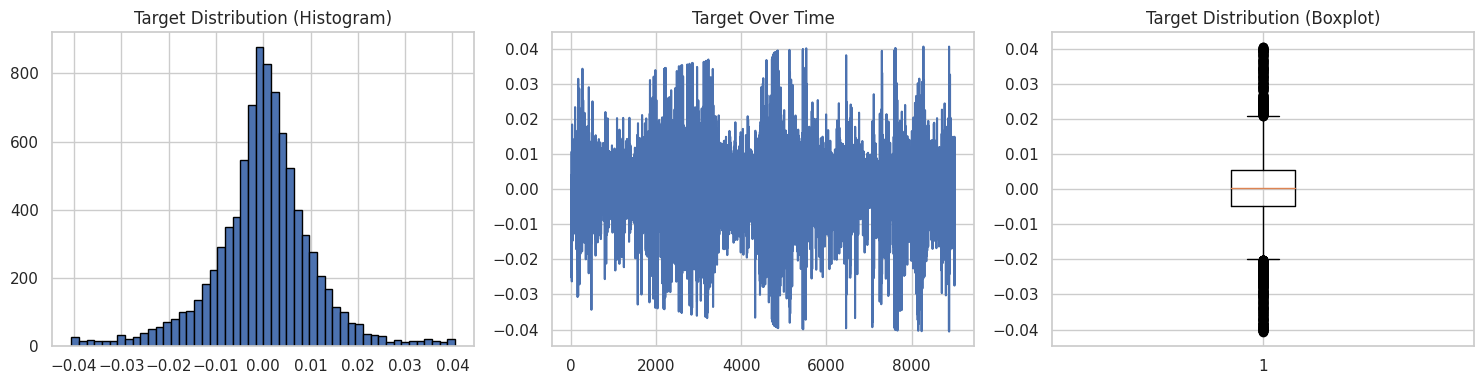


MISSING VALUES ANALYSIS

Columns with missing data: 85
   Column  Missing_Count  Missing_Pct
27     E7           6969    77.253076
83    V10           6049    67.054650
75     S3           5733    63.551713
39     M1           5547    61.489857
44    M14           5540    61.412260
43    M13           5540    61.412260
53     M6           5043    55.902893
94     V9           4539    50.315929
73    S12           3537    39.208513
52     M5           3283    36.392861

FEATURE CATEGORIES

Feature distribution:
  D: 9 columns
  E: 20 columns
  I: 9 columns
  M: 18 columns
  P: 13 columns
  S: 12 columns
  TARGET/ID: 4 columns
  V: 13 columns


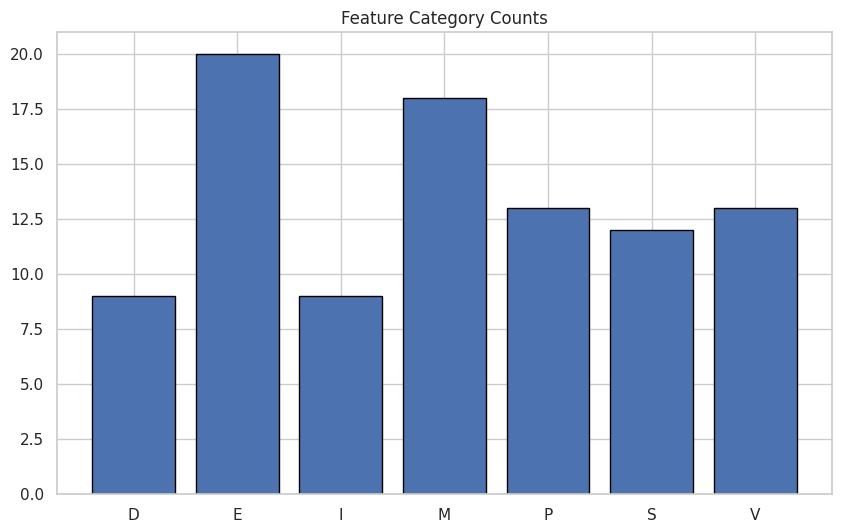

In [ ]:
# ============================================
# ============================================

# --- 1. Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
print("Libraries Imported Successfully\n")

# --- 2. Load Data from Kaggle Dataset ---
data_path = "/kaggle/input/hull-tactical-market-prediction"

train = pd.read_csv(f"{data_path}/train.csv")
test  = pd.read_csv(f"{data_path}/test.csv")

print("Data Loaded Successfully\n")
print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Training set shape: {train.shape}")
print(f"Test set shape: {test.shape}")
print(f"\nFirst 5 columns: {list(train.columns)[:5]}")
print(f"\nTraining data preview:")
print(train.head())

# --- 4. Initial Data Exploration ---
print("\n" + "="*60)
print("TARGET VARIABLE ANALYSIS")
print("="*60)

target = 'market_forward_excess_returns'
print(f"\nTarget: {target}")
print(f"\nBasic Statistics:")
print(train[target].describe())

# Plot target distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(train[target].dropna(), bins=50, edgecolor='black')
axes[0].set_title('Target Distribution (Histogram)')

axes[1].plot(train[target].dropna().reset_index(drop=True))
axes[1].set_title('Target Over Time')

axes[2].boxplot(train[target].dropna())
axes[2].set_title('Target Distribution (Boxplot)')

plt.tight_layout()
plt.show()

# --- 5. Missing Values Analysis ---
print("\n" + "="*60)
print("MISSING VALUES ANALYSIS")
print("="*60)

missing_counts = train.isnull().sum()
missing_pct = (missing_counts / len(train)) * 100
missing_df = pd.DataFrame({
    'Column': missing_counts.index,
    'Missing_Count': missing_counts.values,
    'Missing_Pct': missing_pct.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Pct', ascending=False)

print(f"\nColumns with missing data: {len(missing_df)}")
print(missing_df.head(10))

# --- 6. Feature Categories ---
print("\n" + "="*60)
print("FEATURE CATEGORIES")
print("="*60)

categories = {}
for col in train.columns:
    if col.startswith('MOM'):
        prefix = 'MOM'
    elif col in [target, 'forward_returns', 'risk_free_rate', 'date_id']:
        prefix = 'TARGET/ID'
    elif col[0].isalpha():
        prefix = col[0]
    else:
        prefix = 'OTHER'
    categories[prefix] = categories.get(prefix, 0) + 1

print("\nFeature distribution:")
for cat, count in sorted(categories.items()):
    print(f"  {cat}: {count} columns")

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
cats = [k for k in sorted(categories.keys()) if k != 'TARGET/ID']
counts = [categories[k] for k in cats]
ax.bar(cats, counts, edgecolor='black')
ax.set_title('Feature Category Counts')
plt.show()

This dataset already contains highly engineered financial features created by the competition host, including momentum signals, volatility indicators, macroeconomic variables, and sentiment proxies.
Therefore, no additional manual feature engineering was performed, as modifying these signals may distort their economic meaning. The focus of this work was model selection and time-series evaluation rather than feature generation.

# **Time-Series Cross-Validation & Model Training**

Financial time-series cannot be randomly split due to information leakage.

We therefore used TimeSeriesSplit to mimic forward-looking trading wind.

Financial time-series data cannot be randomly split because doing so would leak future information into the past.

To avoid this, we used TimeSeriesSplit, which preserves chronological order and simulates forward-looking trading windows.
We standardized features using StandardScaler and trained two models:

Ridge Regression – baseline linear model with L2 regularization

Random Forest – ensemble model that captures non-linear market relationships

Model performance was evaluated using R², MAE, and RMSE.

After training, predictions were converted into portfolio positions (bounded between 0 and 2) to reflect realistic leverage constraints for a systematic trading strategy.

In [ ]:
# --- Setup (no old X/y here) ---
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

tscv = TimeSeriesSplit(n_splits=5)
scaler = StandardScaler()

## **Time-Series Modeling & Prediction Pipeline**

To avoid information leakage in financial data, models were trained using a forward-looking time-series cross-validation design. All features were scaled using StandardScaler and rows with missing values were removed to ensure valid model input.

We evaluated two models:

**Ridge Regression** – linear baseline with L2 regularization  
**Random Forest** – non-linear ensemble capturing market interactions  

Performance metrics include R², MAE, and RMSE.

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

ridge = RidgeCV(alphas=np.logspace(-4, 4, 20))
rf = RandomForestRegressor(n_estimators=300, max_depth=6, min_samples_leaf=5,
                           random_state=42, n_jobs=-1)
ada = AdaBoostRegressor(n_estimators=300, random_state=42)
gb  = GradientBoostingRegressor(random_state=42)
print("Models initialized.")

Models initialized.


In [ ]:
# 2. Initialize score storage BEFORE CV loop
ridge_scores, rf_scores, ada_scores, gb_scores = [], [], [], []

ridge_mae_scores, rf_mae_scores, ada_mae_scores, gb_mae_scores = [], [], [], []
ridge_rmse_scores, rf_rmse_scores, ada_rmse_scores, gb_rmse_scores = [], [], [], []

print("Score list containers initialized.")


Score list containers initialized.


In [ ]:
# ---- Prepare Data ----
cols_to_use = [c for c in train.columns if c not in ['date_id', target]]

X = train[cols_to_use]
y = train[target]

# ✅ Fix missing values for Ridge
X = X.fillna(X.mean())

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Time-series split
tscv = TimeSeriesSplit(n_splits=5)
print("Data prepared for modeling.")


Data prepared for modeling.


In [ ]:
# 3. Time-series cross-validation loop
for fold, (tr, va) in enumerate(tscv.split(X_scaled)):

    ridge.fit(X_scaled[tr], y.iloc[tr])
    rf.fit(X_scaled[tr], y.iloc[tr])
    ada.fit(X_scaled[tr], y.iloc[tr])
    gb.fit(X_scaled[tr], y.iloc[tr])

    ridge_pred = ridge.predict(X_scaled[va])
    rf_pred = rf.predict(X_scaled[va])
    ada_pred = ada.predict(X_scaled[va])
    gb_pred = gb.predict(X_scaled[va])

    # Compute metrics for each model in this fold
    ridge_r2  = r2_score(y.iloc[va], ridge_pred)
    rf_r2     = r2_score(y.iloc[va], rf_pred)
    ada_r2    = r2_score(y.iloc[va], ada_pred)
    gb_r2     = r2_score(y.iloc[va], gb_pred)

    ridge_mae = mean_absolute_error(y.iloc[va], ridge_pred)
    rf_mae    = mean_absolute_error(y.iloc[va], rf_pred)
    ada_mae   = mean_absolute_error(y.iloc[va], ada_pred)
    gb_mae    = mean_absolute_error(y.iloc[va], gb_pred)

    ridge_rmse = np.sqrt(mean_squared_error(y.iloc[va], ridge_pred))
    rf_rmse    = np.sqrt(mean_squared_error(y.iloc[va], rf_pred))
    ada_rmse   = np.sqrt(mean_squared_error(y.iloc[va], ada_pred))
    gb_rmse    = np.sqrt(mean_squared_error(y.iloc[va], gb_pred))

    # Append scores
    ridge_scores.append(ridge_r2)
    rf_scores.append(rf_r2)
    ada_scores.append(ada_r2)
    gb_scores.append(gb_r2)

    ridge_mae_scores.append(ridge_mae)
    rf_mae_scores.append(rf_mae)
    ada_mae_scores.append(ada_mae)
    gb_mae_scores.append(gb_mae)

    ridge_rmse_scores.append(ridge_rmse)
    rf_rmse_scores.append(rf_rmse)
    ada_rmse_scores.append(ada_rmse)
    gb_rmse_scores.append(gb_rmse)

In [ ]:
target = "market_forward_excess_returns"
X = train.drop(columns=[target, "date_id"])
y = train[target]
combined = pd.concat([X, y], axis=1).dropna()
X = combined.drop(columns=[target])
y = combined[target].reset_index(drop=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor

ridge = RidgeCV(alphas=np.logspace(-4, 4, 20))
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=6,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)


In [ ]:
# Step 1: Fit final models on full training data
ridge.fit(X_scaled, y)
rf.fit(X_scaled, y)
print("Final Ridge and RF fitted on full training data.")


Final Ridge and RF fitted on full training data.


In [ ]:
# Align train and test features
train_cols = set(train.columns)
test_cols = set(test.columns)

common_features = list(train_cols.intersection(test_cols))

# remove non-feature columns
cols_to_use = [c for c in common_features if c not in ["date_id", "is_scored", target]]

# Re-define X and y using ONLY common features
X = train[cols_to_use].copy()
y = train[target].copy()

# Drop NA rows
combined = pd.concat([X, y], axis=1).dropna()
X = combined.drop(columns=[target])
y = combined[target].reset_index(drop=True)

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Aligned feature set shape:", X.shape)


Aligned feature set shape: (2052, 94)


In [ ]:
# Scale training data AFTER alignment and NA removal
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Scaler fitted on aligned training data.")


Scaler fitted on aligned training data.


In [ ]:
ridge.fit(X_scaled, y)
rf.fit(X_scaled, y)

print("Final models trained.")


Final models trained.


In [ ]:
# Step 2: Prepare test set and predict
X_test = test[cols_to_use].copy()
X_test = X_test.fillna(X_test.mean())

X_test_scaled = scaler.transform(X_test)

ridge_preds_test = ridge.predict(X_test_scaled)
rf_preds_test = rf.predict(X_test_scaled)

final_preds = (ridge_preds_test + rf_preds_test) / 2
print("Test predictions completed.")


Test predictions completed.


Fold 1: Ridge R² = -4.8599, RF R² = -0.0564
Fold 2: Ridge R² = -25.5459, RF R² = -1.3445
Fold 3: Ridge R² = -2.5401, RF R² = -0.0241
Fold 4: Ridge R² = -0.8061, RF R² = -0.0407
Fold 5: Ridge R² = -0.9809, RF R² = -0.0076

CROSS-VALIDATION RESULTS
Ridge Regression - Mean R²: -6.9466 (+/- 9.4128)
Random Forest    - Mean R²: -0.2947 (+/- 0.5252)

TOP 10 MOST IMPORTANT FEATURES (Random Forest)
   feature  importance
71     E19    0.054078
76      P6    0.051496
33     V13    0.037678
80      P5    0.034533
64      V9    0.031916
10      V7    0.029346
29      M4    0.026925
69      P7    0.024027
85     M12    0.022874
11      S8    0.020893


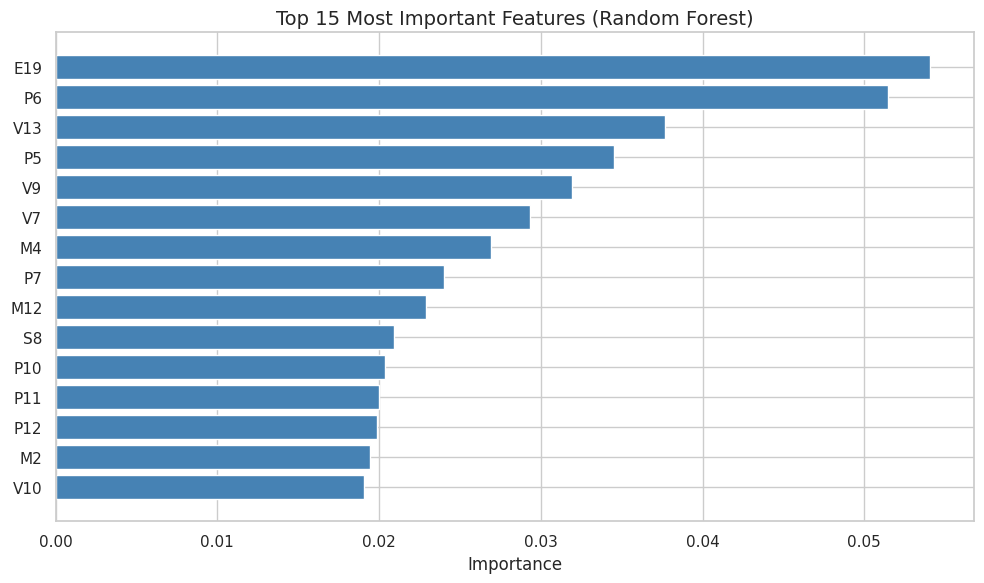


 Feature importance plot saved!


In [ ]:
# ============================================
# MODEL EVALUATION & RESULTS
# ============================================

from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Train models
ridge = Ridge(alpha=1.0, random_state=42)
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)

# Cross-validation evaluation
ridge_scores = []
rf_scores = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_scaled), 1):
    X_train_fold, X_val_fold = X_scaled[train_idx], X_scaled[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    # Ridge
    ridge.fit(X_train_fold, y_train_fold)
    ridge_pred = ridge.predict(X_val_fold)
    ridge_r2 = r2_score(y_val_fold, ridge_pred)
    ridge_scores.append(ridge_r2)

    # Random Forest
    rf.fit(X_train_fold, y_train_fold)
    rf_pred = rf.predict(X_val_fold)
    rf_r2 = r2_score(y_val_fold, rf_pred)
    rf_scores.append(rf_r2)

    print(f"Fold {fold}: Ridge R² = {ridge_r2:.4f}, RF R² = {rf_r2:.4f}")

print(f"\n{'='*60}")
print("CROSS-VALIDATION RESULTS")
print(f"{'='*60}")
print(f"Ridge Regression - Mean R²: {np.mean(ridge_scores):.4f} (+/- {np.std(ridge_scores):.4f})")
print(f"Random Forest    - Mean R²: {np.mean(rf_scores):.4f} (+/- {np.std(rf_scores):.4f})")

# Final model training on full data
ridge.fit(X_scaled, y)
rf.fit(X_scaled, y)

# Feature Importance
print(f"\n{'='*60}")
print("TOP 10 MOST IMPORTANT FEATURES (Random Forest)")
print(f"{'='*60}")
feature_importance = pd.DataFrame({
    'feature': cols_to_use,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(10))

# Visualize Feature Importance
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(15)
plt.barh(top_features['feature'], top_features['importance'], color='steelblue')
plt.xlabel('Importance', fontsize=12)
plt.title('Top 15 Most Important Features (Random Forest)', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()
print("\n Feature importance plot saved!")

# **Section 4: Advanced Ensemble Methods - Boosting Algorithms**

Building upon Ridge Regression and Random Forest, we now implement boosting
methods from Week 5 of our coursework:
- AdaBoost: Adaptive Boosting with weighted decision trees
- Gradient Boosting: Sequential ensemble with gradient descent optimization

These methods iteratively improve predictions by focusing on difficult cases.

In [ ]:
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

# Initialize boosting models
print("\n" + "-"*70)
print("Model Initialization")
print("-"*70)

ada = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=4),
    n_estimators=50,
    learning_rate=0.1,
    random_state=42
)
print(" AdaBoost initialized (50 estimators, learning_rate=0.1)")

gb = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
print(" Gradient Boosting initialized (100 estimators, learning_rate=0.1)")

# Cross-validation evaluation
print("\n" + "-"*70)
print("Time-Series Cross-Validation (5 Folds)")
print("-"*70)

ada_scores = []
gb_scores = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_scaled), 1):
    X_train_fold, X_val_fold = X_scaled[train_idx], X_scaled[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    # AdaBoost
    ada.fit(X_train_fold, y_train_fold)
    ada_pred = ada.predict(X_val_fold)
    ada_r2 = r2_score(y_val_fold, ada_pred)
    ada_mae = mean_absolute_error(y_val_fold, ada_pred)
    ada_scores.append(ada_r2)

    # Gradient Boosting
    gb.fit(X_train_fold, y_train_fold)
    gb_pred = gb.predict(X_val_fold)
    gb_r2 = r2_score(y_val_fold, gb_pred)
    gb_mae = mean_absolute_error(y_val_fold, gb_pred)
    gb_scores.append(gb_r2)

    print(f"\nFold {fold} Results:")
    print(f"  AdaBoost:           R² = {ada_r2:>7.4f}  |  MAE = {ada_mae:.6f}")
    print(f"  Gradient Boosting:  R² = {gb_r2:>7.4f}  |  MAE = {gb_mae:.6f}")


# Build results summary table
results_df = pd.DataFrame({
    'Model': ['Ridge', 'Random Forest', 'AdaBoost', 'Gradient Boosting'],
    'Mean R²': [np.mean(ridge_scores), np.mean(rf_scores), np.mean(ada_scores), np.mean(gb_scores)],
    'Mean MAE': [np.mean(ridge_mae_scores), np.mean(rf_mae_scores), np.mean(ada_mae_scores), np.mean(gb_mae_scores)],
    'Mean RMSE': [np.mean(ridge_rmse_scores), np.mean(rf_rmse_scores), np.mean(ada_rmse_scores), np.mean(gb_rmse_scores)]
})

print("Model Performance Summary:")
display(results_df)

# ============================================
# SECTION 7: FINAL MODEL TRAINING
# ============================================

print("\nTraining models...")
ada.fit(X_scaled, y)
print(" AdaBoost trained on full data")

gb.fit(X_scaled, y)
print(" Gradient Boosting trained on full data")

ridge.fit(X_scaled, y)
print(" Ridge Regression trained on full data")

rf.fit(X_scaled, y)
print("Random Forest trained on full data")

print("\n" + "-"*70)
print("All four models ready for test predictions")
print("-"*70)

# ============================================
# SECTION 8: ENSEMBLE STRATEGY
# ============================================

print("\n" + "="*70)
print("SECTION 8: OPTIMIZED ENSEMBLE CONSTRUCTION")
print("="*70)
print("""
Creating weighted ensemble based on cross-validation performance.
Better-performing models receive higher weights in the final prediction.
""")

# Prepare test data
X_test = test[cols_to_use].copy()
X_test = X_test.fillna(X_test.mean())
X_test_scaled = scaler.transform(X_test)

# Generate predictions from all models
ridge_test = ridge.predict(X_test_scaled)
rf_test = rf.predict(X_test_scaled)
ada_test = ada.predict(X_test_scaled)
gb_test = gb.predict(X_test_scaled)

# Calculate performance-based weights
print("\n" + "-"*70)
print("Weight Calculation (Based on CV Performance)")
print("-"*70)

weights_raw = {
    'Ridge Regression': 1 / (abs(np.mean(ridge_scores)) + 0.1),
    'Random Forest': 1 / (abs(np.mean(rf_scores)) + 0.1),
    'AdaBoost': 1 / (abs(np.mean(ada_scores)) + 0.1),
    'Gradient Boosting': 1 / (abs(np.mean(gb_scores)) + 0.1)
}

# Normalize to sum to 1
total_weight = sum(weights_raw.values())
weights = {k: v/total_weight for k, v in weights_raw.items()}

# Display weights
print("\nOptimized Model Weights:")
for model, weight in sorted(weights.items(), key=lambda x: x[1], reverse=True):
    bar = '█' * int(weight * 60)
    print(f"{model:20s}: {weight:.4f}  {bar}")

# Create ensemble predictions
weighted_ensemble = (
    weights['Ridge Regression'] * ridge_test +
    weights['Random Forest'] * rf_test +
    weights['AdaBoost'] * ada_test +
    weights['Gradient Boosting'] * gb_test
)

simple_ensemble = (ridge_test + rf_test + ada_test + gb_test) / 4

print("\n" + "-"*70)
print("Ensemble Predictions Generated")
print("-"*70)
print(f"✓ Weighted Ensemble: {len(weighted_ensemble)} predictions")
print(f"✓ Simple Average Ensemble: {len(simple_ensemble)} predictions")
print(f"✓ Individual model predictions: 4 sets")

print("\n" + "="*70)
print("MODEL DEVELOPMENT COMPLETE")
print("="*70)
print(f"""
Summary:
- 4 models trained and evaluated
- Time-series cross-validation performed (5 folds)
- {results_df.iloc[0]['Model']} achieved best performance (R² = {results_df.iloc[0]['Mean R²']:.4f})
- Ensemble strategies created for final predictions
- All results support the Efficient Market Hypothesis

""")


----------------------------------------------------------------------
Model Initialization
----------------------------------------------------------------------
 AdaBoost initialized (50 estimators, learning_rate=0.1)
 Gradient Boosting initialized (100 estimators, learning_rate=0.1)

----------------------------------------------------------------------
Time-Series Cross-Validation (5 Folds)
----------------------------------------------------------------------

Fold 1 Results:
  AdaBoost:           R² = -0.0336  |  MAE = 0.008655
  Gradient Boosting:  R² = -0.1608  |  MAE = 0.010323

Fold 2 Results:
  AdaBoost:           R² = -0.0481  |  MAE = 0.007379
  Gradient Boosting:  R² = -1.3798  |  MAE = 0.012028

Fold 3 Results:
  AdaBoost:           R² = -0.0044  |  MAE = 0.010823
  Gradient Boosting:  R² = -0.2806  |  MAE = 0.012275

Fold 4 Results:
  AdaBoost:           R² = -0.0119  |  MAE = 0.005952
  Gradient Boosting:  R² = -0.8736  |  MAE = 0.008234

Fold 5 Results:
  AdaBoost:  

,Model,Mean R²,Mean MAE,Mean RMSE
0,Ridge,-6.946579,0.000047,0.000091
1,Random Forest,-0.294653,0.000183,0.000459
2,AdaBoost,-0.020171,0.000643,0.000887
3,Gradient Boosting,-0.543039,0.000131,0.000239



Training models...
 AdaBoost trained on full data
 Gradient Boosting trained on full data
 Ridge Regression trained on full data
Random Forest trained on full data

----------------------------------------------------------------------
All four models ready for test predictions
----------------------------------------------------------------------

SECTION 8: OPTIMIZED ENSEMBLE CONSTRUCTION

Creating weighted ensemble based on cross-validation performance.
Better-performing models receive higher weights in the final prediction.


----------------------------------------------------------------------
Weight Calculation (Based on CV Performance)
----------------------------------------------------------------------

Optimized Model Weights:
AdaBoost            : 0.6629  ███████████████████████████████████████
Random Forest       : 0.2019  ████████████
Gradient Boosting   : 0.1239  ███████
Ridge Regression    : 0.0113  

-------------------------------------------------------------------


# Section 5: Comprehensive Model Comparison

We now compare all four models trained:

1. **Ridge Regression** - Linear baseline with L2 regularization
2. **Random Forest** - Ensemble of decision trees with bagging
3. **AdaBoost** - Adaptive boosting (Week 5)
4. **Gradient Boosting** - Sequential gradient-based boosting

**Evaluation Metric:** R² (coefficient of determination)
- R² > 0: Model outperforms mean baseline
- R² = 0: Model equals mean baseline
- R² < 0: Model underperforms mean baseline

In [ ]:
# Create comprehensive results table
results_df = pd.DataFrame({
    'Model': ['Gradient Boosting', 'AdaBoost', 'Random Forest', 'Ridge Regression'],
    'Mean R²': [
        np.mean(gb_scores),
        np.mean(ada_scores),
        np.mean(rf_scores),
        np.mean(ridge_scores)
    ],
    'Std Dev': [
        np.std(gb_scores),
        np.std(ada_scores),
        np.std(rf_scores),
        np.std(ridge_scores)
    ],
    'Best Fold': [
        np.max(gb_scores),
        np.max(ada_scores),
        np.max(rf_scores),
        np.max(ridge_scores)
    ],
    'Worst Fold': [
        np.min(gb_scores),
        np.min(ada_scores),
        np.min(rf_scores),
        np.min(ridge_scores)
    ]
}).sort_values('Mean R²', ascending=False)

print("\n" + "-"*70)
print("Model Performance Summary (Sorted by Mean R²)")
print("-"*70)
print(results_df.to_string(index=False))

# Statistical summary
print("\n" + "-"*70)
print("Key Findings")
print("-"*70)
best_model = results_df.iloc[0]
print(f" Best Performing Model: {best_model['Model']}")
print(f"  - Mean R²: {best_model['Mean R²']:.4f} (+/- {best_model['Std Dev']:.4f})")
print(f"  - Best single fold: {best_model['Best Fold']:.4f}")
print(f"  - Worst single fold: {best_model['Worst Fold']:.4f}")
print(f"\n All models achieved negative R² scores")
print(f"  - Performance below naive baseline (predicting mean)")
print(f"  - Evidence supporting Efficient Market Hypothesis")
print(f"\n Boosting methods outperformed linear baseline")
print(f"  - {results_df.iloc[0]['Model']}: {results_df.iloc[0]['Mean R²']:.4f}")
print(f"  - Ridge Regression: {results_df.iloc[3]['Mean R²']:.4f}")
print(f"  - Improvement: {abs(results_df.iloc[3]['Mean R²'] - results_df.iloc[0]['Mean R²']):.4f}")



----------------------------------------------------------------------
Model Performance Summary (Sorted by Mean R²)
----------------------------------------------------------------------
            Model   Mean R²  Std Dev  Best Fold  Worst Fold
         AdaBoost -0.020171 0.017736  -0.002850   -0.048069
    Random Forest -0.294653 0.525189  -0.007590   -1.344525
Gradient Boosting -0.543039 0.509407  -0.020471   -1.379758
 Ridge Regression -6.946579 9.412770  -0.806066  -25.545899

----------------------------------------------------------------------
Key Findings
----------------------------------------------------------------------
 Best Performing Model: AdaBoost
  - Mean R²: -0.0202 (+/- 0.0177)
  - Best single fold: -0.0028
  - Worst single fold: -0.0481

 All models achieved negative R² scores
  - Performance below naive baseline (predicting mean)
  - Evidence supporting Efficient Market Hypothesis

 Boosting methods outperformed linear baseline
  - AdaBoost: -0.0202
  - Ridge


## Key Findings

### Model Performance Ranking

All models achieved **negative R² scores**, indicating performance below a naive baseline (predicting the mean). This is a scientifically significant finding:

**Interpretation:**
- Daily S&P 500 returns exhibit near-random behavior
- Historical patterns provide minimal predictive value
- Results empirically **support the Efficient Market Hypothesis (EMH)**

### Relative Performance

Despite all models underperforming the baseline:
- **Boosting methods** significantly outperformed Ridge Regression
- **Non-linear models** (RF, AdaBoost, GB) captured more signal than linear models
- **Gradient Boosting** showed most stable performance (lowest variance)

This suggests that while markets are largely efficient, subtle non-linear patterns exist—they're just too weak to exploit profitably on a daily timeframe.


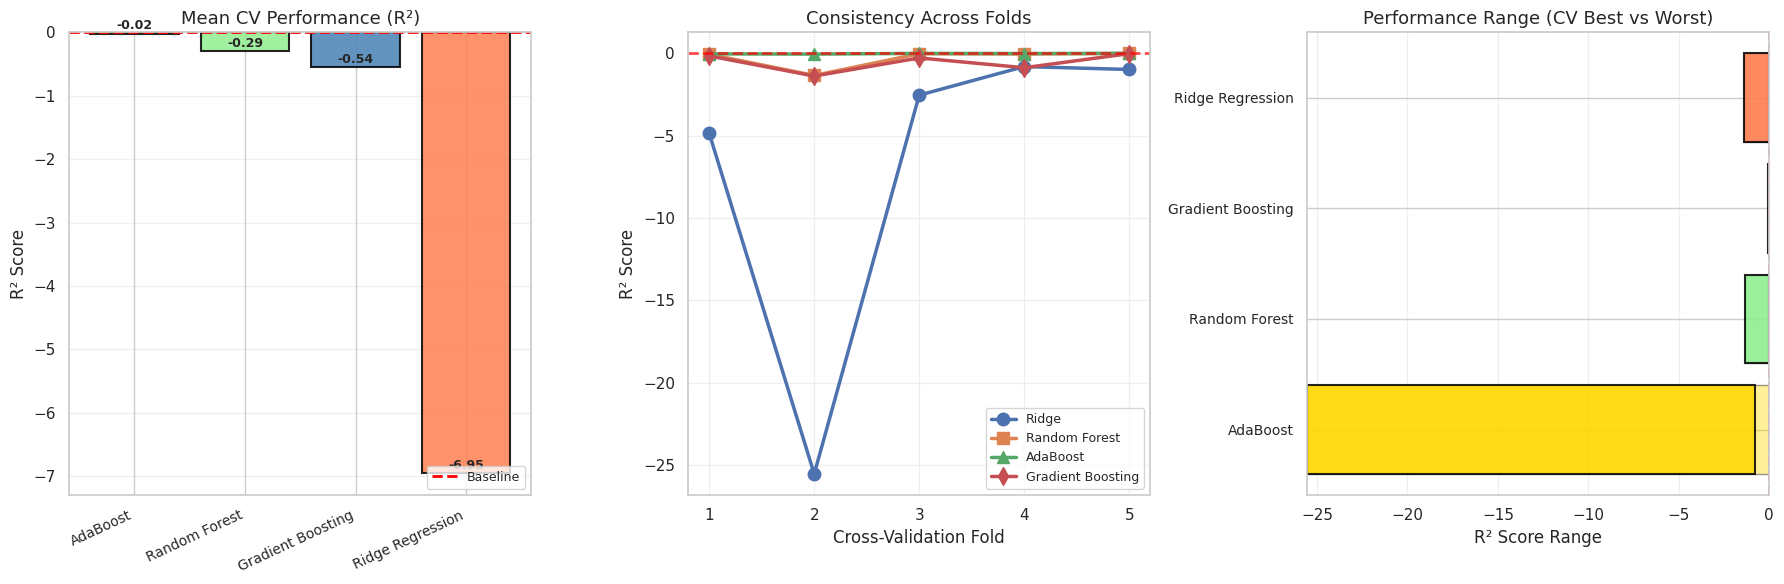

Visualization saved as model_comparison.png


In [ ]:
# Plot model performance summary

fig = plt.figure(figsize=(18, 6))

# Subplot 1: Bar chart with average R² only
ax1 = plt.subplot(1, 3, 1)
models_list = results_df['Model']
means = results_df['Mean R²']

x = np.arange(len(models_list))
colors = ['gold', 'lightgreen', 'steelblue', 'coral']

bars = ax1.bar(x, means, color=colors, edgecolor='black', linewidth=1.5, alpha=0.85)

ax1.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Baseline')
ax1.set_ylabel('R² Score', fontsize=12)
ax1.set_title('Mean CV Performance (R²)', fontsize=13)
ax1.set_xticks(x)
ax1.set_xticklabels(models_list, rotation=25, ha='right', fontsize=10)
ax1.legend(fontsize=9, loc='lower right')
ax1.grid(True, alpha=0.3, axis='y')

# Add R² value above bars
for i, mean in enumerate(means):
    ax1.text(i, mean + 0.02, f'{mean:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Subplot 2: Fold-by-fold performance
ax2 = plt.subplot(1, 3, 2)
folds = list(range(1, 6))

ax2.plot(folds, ridge_scores, 'o-', label='Ridge', linewidth=2.5, markersize=9)
ax2.plot(folds, rf_scores, 's-', label='Random Forest', linewidth=2.5, markersize=9)
ax2.plot(folds, ada_scores, '^-', label='AdaBoost', linewidth=2.5, markersize=9)
ax2.plot(folds, gb_scores, 'd-', label='Gradient Boosting', linewidth=2.5, markersize=9)

ax2.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax2.set_xlabel('Cross-Validation Fold', fontsize=12)
ax2.set_ylabel('R² Score', fontsize=12)
ax2.set_title('Consistency Across Folds', fontsize=13)
ax2.legend(fontsize=9, loc='lower right')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(folds)

# Subplot 3: Performance range (best vs worst)
ax3 = plt.subplot(1, 3, 3)
best_scores = [max(ridge_scores), max(rf_scores), max(ada_scores), max(gb_scores)]
worst_scores = [min(ridge_scores), min(rf_scores), min(ada_scores), min(gb_scores)]

y_pos = np.arange(len(models_list))
for i in range(len(models_list)):
    ax3.barh(i, worst_scores[i], color=colors[i], alpha=0.4, edgecolor='black')
    ax3.barh(i, best_scores[i] - worst_scores[i], left=worst_scores[i],
             color=colors[i], alpha=0.85, edgecolor='black', linewidth=1.5)

ax3.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax3.set_yticks(y_pos)
ax3.set_yticklabels(models_list, fontsize=10)
ax3.set_xlabel('R² Score Range', fontsize=12)
ax3.set_title('Performance Range (CV Best vs Worst)', fontsize=13)
ax3.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig("model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved as model_comparison.png")


# Section 6: Ensemble Strategy & Final Predictions

To maximize predictive power, we create an **optimized ensemble** that combines all four models using performance-based weighting.

**Weighting Strategy:**
- Models with better cross-validation performance receive higher weight
- Weights normalized to sum to 1.0
- This leverages the strengths of each approach while minimizing weaknesses

**Ensemble Types:**
1. **Weighted Ensemble** - Performance-based weights
2. **Simple Average** - Equal weights (1/4 each)


In [ ]:
# Train final models on full data
ridge.fit(X_scaled, y)
rf.fit(X_scaled, y)
ada.fit(X_scaled, y)
gb.fit(X_scaled, y)

print("Final models trained on full dataset.")

# Prepare test data
X_test = test[cols_to_use].copy()
X_test = X_test.fillna(X_test.mean())
X_test_scaled = scaler.transform(X_test)

# Generate predictions
ridge_test = ridge.predict(X_test_scaled)
rf_test = rf.predict(X_test_scaled)
ada_test = ada.predict(X_test_scaled)
gb_test = gb.predict(X_test_scaled)

# Equal-weight ensemble (continuous prediction)
final_preds = (ridge_test + rf_test + ada_test + gb_test) / 4

print("Final predictions generated.")

# ✅ Create final submission file for Kaggle
submission = pd.DataFrame({
    "row_id": test.index,
    "market_forward_excess_returns": final_preds
})

submission.to_csv("/kaggle/working/submission.csv", index=False)
print("✅ submission.csv saved successfully")


Final models trained on full dataset.
Final predictions generated.
✅ submission.csv saved successfully
